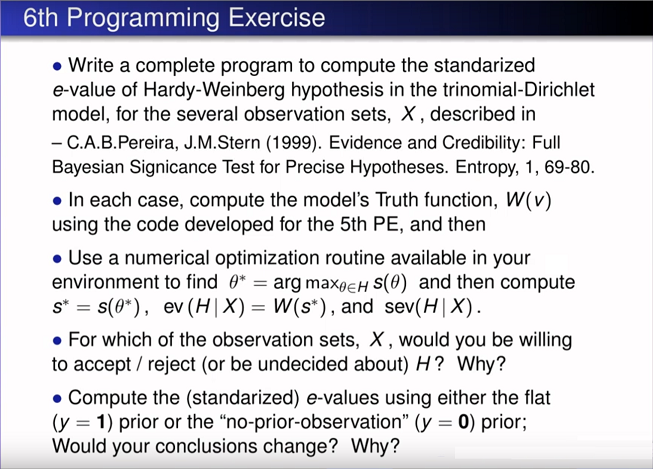

In [4]:
#Bibliotecas
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.stats import chi2
from scipy.optimize import minimize_scalar
np.random.seed(42) # O número 42 pode ser qualquer inteiro

In [5]:
#INFO da dupla
INFO = {5381328:"Nikolas Lukin",11811012:"Vinícius Collaço"}

class Estimador:
  """
  Classe para criar o objeto, ele recebe valores para os vetores x e y.
  Os metodos definidos abaixo serao utilizadas por um corretor automatico. 
  Portanto, precisa manter os outputs e inputs dos 2 metodos abaixo. 
  """
  def __init__(self,x,y):
    """
    Inicializador do objeto. Este metodo recebe 
    valores pros vetores x e y em formato de lista 
    e implementa no objeto. 
    """
    
    self.vetor_x = np.array(x) #formato: [0,0,0] - List cujo len(x) = 3
    self.vetor_y = np.array(y) #formato: [0,0,0] - List cujo len(y) = 3

    self.alpha = self.vetor_x + self.vetor_y
    self.n = 20000 #Definido no relatorio
    self.queima = 1000
    self.k = 4000 #Numero de bins definido no relatorio

    #calcula a constante de normalização
    beta = (np.prod(gamma(self.alpha))) / (gamma(sum(self.alpha)))
    self.const_norm = 1/beta

    self.covariancia = self.matriz_de_covariancia()   
    self.M_cov_reduzida = self.covariancia[:2, :2]
    

    self.potenciais = self.amostra_MCMC(self.vetor_x, self.vetor_y, self.n)
    self.f_ordenada = self.f_norm_ord()
    self.f_min = self.f_ordenada[0]
    self.f_max = self.f_ordenada[-1]
    self.f_bins = self.f_bins()

    self.t = 2 #Dimensao do espaco parametrico
    self.h = 1 #Dimensao do espaco parametrico de Ho

    self.theta_star = self.func_theta_star()
    self.e_valor = self.U(self.theta_star)
    self.sev = self.sev(self.t, self.h, self.e_valor)

  def matriz_de_covariancia(self):
    """
    Funcao que gera a matriz de covariancia sigma, 
    com base na variancia e covariancia da 
    https://en.wikipedia.org/wiki/Dirichlet_distribution
    """
    size = len(self.alpha)
    M_sigma = np.identity(size)
    a_0 = sum(self.alpha)
      
    for i in range(size):
      for j in range(size):
        if i == j:#Variancia da Dirichilet            
          M_sigma[i][j] = (a_0 - self.alpha[i])*self.alpha[i]/((a_0**2)*(a_0 + 1))            
        else:#Covariancia da Dirichilet
          M_sigma[i][j] = -1*self.alpha[i]*self.alpha[j]/((a_0**2)*(a_0 + 1))   
    
    return M_sigma

  def gera_candidato(self, atual):
    """metodo para gerar um ponto candidato no simplex"""
    while True:
      passo = np.random.multivariate_normal([0, 0], self.M_cov_reduzida)
      candidato = ([atual[0] + passo[0],
                    atual[1] + passo[1],
                    1 - (atual[0] + passo[0] + atual[1] + passo[1])]
                  )
      if all(i > 0 for i in candidato) > 0:
        return candidato
  
  def f_theta(self,theta):
    """metodo para calcular o potencial de f(theta)"""
    f = np.prod(np.power(theta, self.alpha - 1))
    return f
  
  def amostra_MCMC(self, x, y, n):
    """
    Funcao que recebe valores pros vetores x e y, o tamanho n da amostra, 
    gera uma amostra de tamanho n a partir do metodo de monte carlo via 
    cadeias de markov, onde cada elemento da amostra tem tamanho 3 (vetor),
    e retorna uma lista de tamanho n com os potenciais de cada ponto obtido,
    onde cada elemento tem tamanho 1 (escalar).
    
    Nao utilize a fuancao densidade de probabilidade, apenas a funcao potencial!
    """
    amostras = [[1/3, 1/3, 1/3]] #ponto inicial, centro do simplex
    alpha = np.array(x) + np.array(y)

    for _ in range(n + self.queima):
      candidato = self.gera_candidato(amostras[-1])

      #probabilidade de aceitacao
      prob = min(1, self.f_theta(candidato) / self.f_theta(amostras[-1]))

      #aceita com a probabilidade calculada
      if np.random.random() < prob:
        amostras.append(candidato)  
      else:
        amostras.append(amostras[-1])

    amostra_de_potenciais = np.prod(np.power(np.array(amostras), alpha - 1), axis=1)
    return amostra_de_potenciais[self.queima+1:] # Exemplo do formato = [0.04867, 0.00236, 0.00014 ... ]

  def f_norm_ord(self):
    """metodo para normalizar e ordenar a potencial gerada da cadeia de Markov"""
    f = self.potenciais
    f.sort()
    f_normalizada = f*self.const_norm

    return f_normalizada
  
  def f_bins(self):
    """metodo para separar a f em bins"""

    f_normalizada = self.f_ordenada
    f_bins = [0]*self.k

    #Separa em bins com uma quantidade constante de pontos cada bin
    passo = int(self.n/self.k)

    for i in range (0,self.k):
      f_bins[i] = f_normalizada[i*passo]

    return f_bins
  
  def U(self,v):
    """
    Este metodo recebe um valor para v e, a partir dele, retorna U(v|x,y) 
    a partir dos vetores x e y inicializados anteriormente
    """
    f_ordenado = self.f_bins

    if v > self.f_max:
      return 1
    if v < self.f_min:
      return 0  

    # numero de bins abaixo de um certo v
    menor_que_v = np.searchsorted(f_ordenado, v, side='left')
    u = menor_que_v/self.k

    return u    
  
  def func_theta_star(self):

    def Ho(theta1):
      """Definicao do espaco parametrico de Ho"""
      theta2 = 1 - theta1 - np.power((1 - np.sqrt(theta1)), 2)
      theta3 = np.power((1 - np.sqrt(theta1)), 2)
      return  np.array([theta1, theta2, theta3])
  
    def s_star(x):
      """S* para maximizar dentro de Ho"""
      return(-self.f_theta(Ho(x)))

    """função que maximiza e retorna theta estrela normalizada"""
    potencial_max =  minimize_scalar(s_star,
                                    bounds=(0.0, 1.0), 
                                    method='Bounded')  
    return -potencial_max.fun*self.const_norm

  
  def sev(self, t, h, e_valor): 
    """calcula o e-valor padronizado (SEV)"""
    df = t - h #graus de liberdade
    ev_barra = 1 - e_valor 
    qq = chi2.cdf(chi2.ppf(ev_barra, t), df) #função QQ

    return 1 - qq #QQ_barra


In [6]:
def main():
  #Coloque seus testes aqui
  x1_x3 = np.array([[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], 
                    [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], 
                    [1, 15], [1, 16], [1, 17], [1, 18], [5, 0], [5, 1], 
                    [5, 2], [5, 3], [5, 4], [5, 5], [5, 6], [5, 7], [5, 8], 
                    [5, 9], [5, 10], [9, 0], [9, 1], [9, 2], [9, 3], [9, 4], 
                    [9, 5], [9, 6], [9, 7]])
 
  vetores_x = np.insert(x1_x3, 1, 20-x1_x3[:,0]-x1_x3[:,1], axis=1) #x2=20-x1-x3
  vetores_y = np.array([[0, 0, 0], [1, 1, 1]])

  #print("x1\tx3\ty\tDecisão\tθ*\tev\tsev")
  for y in vetores_y:
    for x in vetores_x:
      objeto = Estimador(x, y)
      if objeto.sev < 0.05:
        decisao = 'Rejeita Ho'
      else:
        decisao = 'Não Rejeita Ho'

      print(f"x1={x[0]}, x3={x[2]}, Y= {y}, H={decisao},  θ*= {objeto.theta_star}, ev(H|X)={objeto.e_valor} e sev(H|X)={objeto.sev}")

      '''print(f"{x[0]: ^2}\
      {x[2]: ^2}\
      {y}\
      {decisao}\
      {objeto.theta_star}\
      {objeto.e_valor}\
      {objeto.sev}")'''
  


if __name__ == "__main__":
    main()
main()

x1=1, x3=2, Y= [0 0 0], H=Rejeita Ho,  θ*= 0.023523210392836263, ev(H|X)=0 e sev(H|X)=0.0
x1=1, x3=3, Y= [0 0 0], H=Rejeita Ho,  θ*= 0.11231016722421507, ev(H|X)=0.00175 e sev(H|X)=0.00036638391864851627
x1=1, x3=4, Y= [0 0 0], H=Rejeita Ho,  θ*= 0.37762800245700684, ev(H|X)=0.0055 e sev(H|X)=0.0012560554683488379
x1=1, x3=5, Y= [0 0 0], H=Rejeita Ho,  θ*= 1.0036414673255534, ev(H|X)=0.02325 e sev(H|X)=0.006091951911743276
x1=1, x3=6, Y= [0 0 0], H=Rejeita Ho,  θ*= 2.244538764250946, ev(H|X)=0.0675 e sev(H|X)=0.020237906176635234
x1=1, x3=7, Y= [0 0 0], H=Rejeita Ho,  θ*= 4.392511878467612, ev(H|X)=0.1205 e sev(H|X)=0.03966373836767878
x1=1, x3=8, Y= [0 0 0], H=Não Rejeita Ho,  θ*= 7.72658577353792, ev(H|X)=0.248 e sev(H|X)=0.09493399243658884
x1=1, x3=9, Y= [0 0 0], H=Não Rejeita Ho,  θ*= 12.458927200534099, ev(H|X)=0.3535 e sev(H|X)=0.14926524854178425
x1=1, x3=10, Y= [0 0 0], H=Não Rejeita Ho,  θ*= 18.697984426099712, ev(H|X)=0.505 e sev(H|X)=0.2424324636877635
x1=1, x3=11, Y= [0 0 